In [67]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [68]:
offers_connection = sqlite3.connect('../datasets/offers_dataset.db')
offers_frame = pd.read_sql_query('''SELECT * FROM offers''', offers_connection)
offers_connection.close()

# [!] Le descrizioni all'interno del notebook non sono mostrate nella loro versione completa
#     per accedere ad una specifica descrizione usare il metodo: offers_frame.loc[ID, NomeColonna]
offers_frame

,Name,Description,Location
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria"
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata"
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia"
...,...,...,...
165,Data Scientist - Pharma,Akkodis è un leader globale nel mercato dell'i...,"Provincia di Torino, Piemonte"
166,DATA SCIENTIST | MACHINE LEARNING | BIG DATA,Techyon: Information Technology Recruitment Ex...,"Parma, Emilia-Romagna"
167,PDS AD&GMP Scientist I,Job DescriptionWhen you’re part of Thermo Fish...,20900 Monza
168,Junior Ethical Data Scientist,We are looking for an extremely BOLD & VISIONA...,None


## Data Exploration
Come prima cosa esaminiamo il nostro dataset di offerte, in particolare dovremmo verificare la qualità dei dati:
- Base   
    - Presenza di valori nulli
    - (**Importante**) Presenza di sinonimi geografici
    - Presenza di informazioni utili
- Avanzato
    - Analisi delle Parole Chiave (es. Titoli)
    - Analisi della distribuzione dei dati

**Presenza di Valori Nulli e Duplicati**
Come è possibile vedere di seguito il dataset contiene valori nulli solo per la colonna Location, il che però è normale, in quanto non tutte le Offerte di lavoro sono in presenza, quindi le Location mancanti rappresentano il numero di Offerte di lavoro in Remote.
Questa informazione è importante perchè in seguito ci sarà la necessità di rappresentare queste informazioni in modo omogeneo, in modo tale che un modello il cui scopo è raggruppare le Offerte (clustering, come proposto nell'Analisi del Problema) possa farlo in modo adeguato.

In [69]:
offers_frame.dropna(subset='Name',inplace=True)
offers_frame.drop_duplicates(inplace=True)
offers_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 0 to 169
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         168 non-null    object
 1   Description  168 non-null    object
 2   Location     134 non-null    object
dtypes: object(3)
memory usage: 5.2+ KB


## Presenza di Sinonimi Geografici
Il dataset contiene attualmente molteplici istanze in cui la stessa Location è riportata in modi diversi, come \<Cap>, \<Città> e \<Città>, \<Regione>.


In [70]:
#example_city = "Bologna"

#onsite_offers = offers_frame[offers_frame["Location"].notna()]
#geo_syn = onsite_offers.Location.map(lambda text: example_city in text)
#onsite_offers[geo_syn]

**Analisi dei Titoli**
Di seguito vengono analizzati i Titoli delle Offerte di lavoro con lo scopo di verificare la presenza di termini comuni, in particolare vengono usate delle basilari tecniche di Natural Language Processing come:
- **Tokenization**, utilizzata per dividere frasi o documenti in parole (*title.split()*) 
- **Rimozione della Punteggiatura**, utilizzata per migliorare la qualità dei dati estratti, in modo da non influenzare i risultati 
- **Normalizzazione**, utilizzata per ridurre la complessità del vocabolario e trattare parole con maiuscole e minuscole come equivalenti (*t.lower()*)

In [71]:
from string import punctuation
from collections import Counter

def count_words(document: str, counter: Counter):
    """
    :param document: a string representation of the document to inspect
    :param counter: a Python built-in object used to count occurrences of items
    """
    punct = [p for p in punctuation]
    for t in document.split():
        if not t in punct:
            counter[t.lower()] += 1


titles_counts = Counter()
offers_frame.Name.map(lambda text: count_words(text, titles_counts))

titles_counts

Counter({'developer': 54,
         'software': 44,
         'engineer': 39,
         'network': 21,
         'junior': 18,
         'web': 15,
         'senior': 13,
         'data': 13,
         'intern': 10,
         'scientist': 10,
         'sviluppatore': 9,
         'frontend': 8,
         'full': 8,
         '2024': 8,
         'backend': 8,
         'analyst': 6,
         'development': 5,
         'programmatore': 5,
         'stack': 5,
         'engineering': 5,
         'graduate': 5,
         'security': 5,
         'learning': 5,
         'c#': 4,
         'remote)': 4,
         'manager': 4,
         'java': 3,
         'ai': 3,
         'front-end': 3,
         'remote': 3,
         'apprenticeship': 3,
         '(london)': 3,
         'front': 3,
         'end': 3,
         'lead': 3,
         'system': 3,
         'summer': 3,
         'intelligence': 3,
         'internship': 3,
         '–': 3,
         'consultant': 3,
         'specialist': 3,
         'reliabilit

Analisi delle occorrenze di parole:

In [72]:
# Jacopo plotta qui

## Data Preparation
Per permettere il completo soddisfacimento dei requisiti, alcuni dati mancanti alle offerte dovranno essere aggiunti al dataset, tra cui:
- RequiredSkills: le Competenze richieste da una Offerta
- LocationType: il tipo di Location, se in remoto (Remote) o in sede (OnSite)
- Languages: le lingue naturali necessarie per l'offerta di lavoro

### Skill Extraction
Per procedere con l'estrazione delle Competenze dalle Offerte per prima cosa importiamo il relativo dataset.   

In [73]:
# [!] In alcune descrizioni di offerte c'è HTML5 o CSS3 che non vengono riconosciuti come HTML o CSS

with sqlite3.connect('../datasets/skills_dataset.db') as skills_connection:
    skills_frame = pd.read_sql_query('SELECT * FROM skills', skills_connection)
    skills_frame.set_index('ID', inplace=True)
    
skills_frame

,SKILL,TYPE
ID,,
0,JavaScript,Programming Language
1,HTML,Programming Language
2,Python,Programming Language
3,SQL,Programming Language
4,TypeScript,Programming Language
...,...,...
95,APT,Tool
96,Unity 3D,Tool
97,Pacman,Tool


In [74]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def remove_symbols(description: str, remove_map: dict) -> str:
    """
    """
    for old, new in remove_map.items():
        description = description.replace(old, new)
    return description.lower()

def extract_symbols(text: str, available_symbols: list) -> set:
    """
    """
    out = set()
    for token in set(word_tokenize(text)):
        if token.lower() in available_symbols:
           out.add(token)
    return out

"""
def extract_symbols(description: str, available_symbols: list) -> set:
    s = set()
    for word in description.split():
        if word in available_symbols:
            s.add(word)
    return s 
"""

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'\ndef extract_symbols(description: str, available_symbols: list) -> set:\n    s = set()\n    for word in description.split():\n        if word in available_symbols:\n            s.add(word)\n    return s \n'

In [75]:
# Get Skill list
skills_list = [skill.lower() for skill in skills_frame['SKILL'].tolist()]

# Symbols to remove
punct = [p for p in punctuation]
punct.remove('+')
punct.remove('#')
punct.remove('.')

removal = {p: '' for p in punct}
removal['\n'] = ''
removal['/'] = ' '
removal['('] = ' '
removal[')'] = ' '
removal[','] = ' '

In [76]:
# offers_frame['RequiredSkills'] = ''
with_no_skills = 0

required_skills_tmp = [] # used for the skill analysis section below

for i, offer_description in enumerate(offers_frame.loc[:, 'Description']):
    desc = remove_symbols(offer_description, removal)
    offer_skills = extract_symbols(desc, skills_list)
    if not offer_skills:
        with_no_skills += 1
        # print(f'{i}: No Skills')
        # print(desc)
    else:
        # print(f'{i}: {offer_skills}')
        # offers_frame.loc[i, "RequiredSkills"] = ', '.join(offer_skills)
        required_skills_tmp.append(offer_skills)

print(f'There are {with_no_skills} Offers with no skills available')
# offers_frame

There are 47 Offers with no skills available


**Frequenza di Skill**

Una analisi delle Competenze più richieste può essere utile per guidare la scelta di metriche e algoritmi, per esempio si potrebbe pensare di dare una rilevanza maggiore a Competenze più richieste durante il processo di raccomandazione, dando una priorità più elevata a Offerte che richiedono quelle più richieste oppure a Sviluppatori che le posseggono.

In [77]:
skill_counter = Counter()
for offer_requirements in required_skills_tmp:
    for r in offer_requirements:
        skill_counter[r] += 1
skill_plot = {s: c for s, c in skill_counter.most_common(10)}

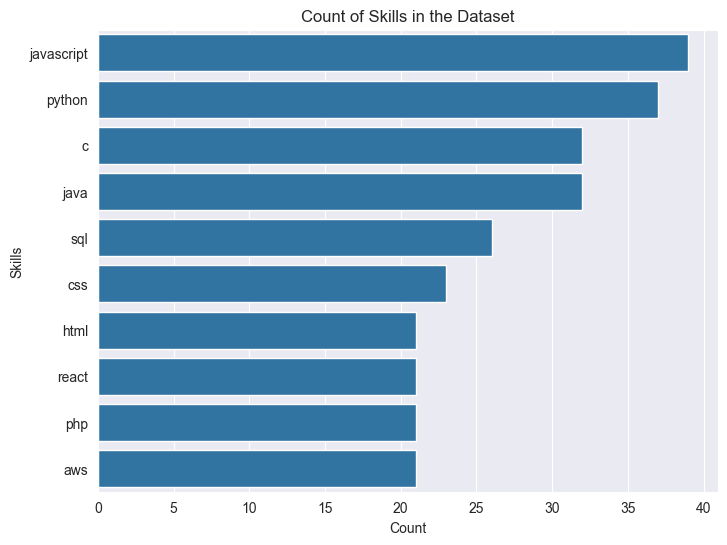

In [78]:
# A Bar-Plot is useful to easily represent a trend
plt.figure(figsize=(8, 6))
sns.barplot(x=skill_plot.values(), y=skill_plot.keys())
plt.title("Count of Skills in the Dataset")
plt.xlabel("Count")
plt.ylabel("Skills")
plt.show()

### Tipo di Location
Per estrarre il tipo di Location dalle informazioni attualmente già presenti nel dataset, 
saranno interpretate come di tipo Remote tutte le offerte che non presentano una Location.

In [79]:
LOCATION_TYPES = {"Remote" : "Remote", "On Site" : "OnSite"}
locations_present = offers_frame["Location"].notna()
types = []

for is_present in locations_present:
    if is_present:
        types.append(LOCATION_TYPES["On Site"])
    else:
        types.append(LOCATION_TYPES["Remote"])

offers_frame.loc[:, "LocationType"] = types

offers_frame

,Name,Description,Location,LocationType
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria",OnSite
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,OnSite
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,OnSite
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata",OnSite
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia",OnSite
...,...,...,...,...
165,Data Scientist - Pharma,Akkodis è un leader globale nel mercato dell'i...,"Provincia di Torino, Piemonte",OnSite
166,DATA SCIENTIST | MACHINE LEARNING | BIG DATA,Techyon: Information Technology Recruitment Ex...,"Parma, Emilia-Romagna",OnSite
167,PDS AD&GMP Scientist I,Job DescriptionWhen you’re part of Thermo Fish...,20900 Monza,OnSite
168,Junior Ethical Data Scientist,We are looking for an extremely BOLD & VISIONA...,None,Remote


### Linguaggi Richiesti
Per dedurre quali lingue parlate sono richieste da una data offerta di lavoro, viene utilizzato il modulo langdetect per identificare la lingua in cui è stata scritta la descrizione dell'offerta stessa, e successivamente tramite una ricerca all'interno del testo della descrizione per menzioni di ulteriori lingue.

In [80]:
from langdetect import detect
offers_langs = []
remove_map = {p:'' for p in punctuation}
supported_langs = ['italiano', 'inglese', 'italian', 'english']
eqs = [('italiano', 'italian'), ('inglese', 'english')]

for desc in offers_frame.Description:
    lang = detect(desc)
    if lang == 'it':
        lang = 'italiano'
    elif lang == 'en':
        lang = 'inglese'
    
    desc = remove_symbols(desc, remove_map)
    found = extract_symbols(desc, supported_langs)
    found.add(lang)
    found = list(found)
    
    for i, l in enumerate(found):
        for e in eqs:
            if l in e:
                found[i] = e[0]
                break
    
    offers_langs.append(found)
    
offers_frame.loc[:, "Languages"] = offers_langs

offers_frame

,Name,Description,Location,LocationType,Languages
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria",OnSite,"[inglese, inglese]"
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,OnSite,[italiano]
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,OnSite,"[inglese, inglese]"
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata",OnSite,[inglese]
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia",OnSite,[italiano]
...,...,...,...,...,...
165,Data Scientist - Pharma,Akkodis è un leader globale nel mercato dell'i...,"Provincia di Torino, Piemonte",OnSite,[italiano]
166,DATA SCIENTIST | MACHINE LEARNING | BIG DATA,Techyon: Information Technology Recruitment Ex...,"Parma, Emilia-Romagna",OnSite,[italiano]
167,PDS AD&GMP Scientist I,Job DescriptionWhen you’re part of Thermo Fish...,20900 Monza,OnSite,[inglese]
168,Junior Ethical Data Scientist,We are looking for an extremely BOLD & VISIONA...,None,Remote,"[inglese, italiano, inglese]"


**Distribuzione delle Lingue Richieste**

Per verificare che il dataset fornisca una buona rappresentazione della realtà è sempre buona norma verificare la distribuzione dei dati, in alcuni casi, per la natura del problema, è impossibile avere un campionario bilanciato e bisogna ricorrere a tecniche *estreme* per ottenere un dataset la cui distribuzione non generi bias nei modelli di Machine Learning applicati, nel nostro caso invece basta ritornare alla fase di collezione dei dati; per questo motivo di seguito viene mostrata la distribuzione delle Lingue Richieste da una offerta. 

In [81]:
# The count is executed given the assumption that the Required Languages can be Italian or English
language_counter = Counter()
for offer_languages in offers_frame.loc[:, 'Languages']:
    if len(set(offer_languages)) == 2:
        language_counter['both'] += 1
    else:
        for l in set(offer_languages):
            language_counter[l] += 1

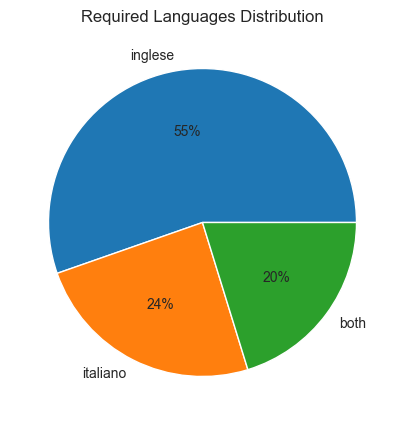

In [82]:
# A Pie-Chart is one of the best tools to analyze distribution given the visual nature
plt.figure(figsize=(5, 5))
plt.title('Required Languages Distribution')
plt.pie(language_counter.values(), labels=language_counter.keys(), autopct='%0.f%%')
plt.show()